# KNN

In [1]:
import IPython
import random
import statistics
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import sklearn

---

## Dataset

Boston Housing Prices Data Set. This used to be housed by [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Housing), but it is not housed there any more. You can read about it at [Kaggle](https://www.kaggle.com/vikrishnan/boston-house-prices) and at the [University of Toronto](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html).


In [2]:
from sklearn.datasets import load_boston
bdata = load_boston()

The following commands will provide some basic information about the shape of the data:

In [3]:
print (bdata.keys())
print (bdata.feature_names)
print (bdata.data.shape)
print (bdata.target.shape)
print (bdata.data)

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
(506, 13)
(506,)
[[6.3200e-03 1.8000e+01 2.3100e+00 ... 1.5300e+01 3.9690e+02 4.9800e+00]
 [2.7310e-02 0.0000e+00 7.0700e+00 ... 1.7800e+01 3.9690e+02 9.1400e+00]
 [2.7290e-02 0.0000e+00 7.0700e+00 ... 1.7800e+01 3.9283e+02 4.0300e+00]
 ...
 [6.0760e-02 0.0000e+00 1.1930e+01 ... 2.1000e+01 3.9690e+02 5.6400e+00]
 [1.0959e-01 0.0000e+00 1.1930e+01 ... 2.1000e+01 3.9345e+02 6.4800e+00]
 [4.7410e-02 0.0000e+00 1.1930e+01 ... 2.1000e+01 3.9690e+02 7.8800e+00]]


---

##Part 1: Descriptive analysis


###1.1: Histogram of housing prices


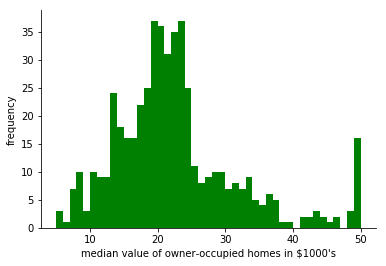

In [4]:
%matplotlib inline  
import matplotlib.pyplot as plt  

fig, ax = plt.subplots()
ax.hist(bdata.target, bins=int(max(bdata.target)-min(bdata.target)),color = "green", lw=0)
plt.xlabel('median value of owner-occupied homes in $1000\'s')
plt.ylabel('frequency')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

###1.2: Scatter plot of housing prices and crime


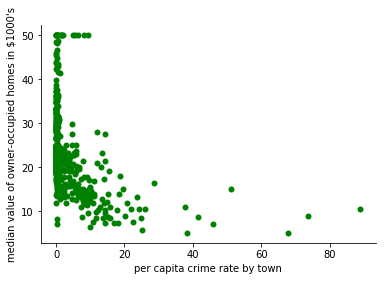

In [5]:
boston = pd.DataFrame(bdata.data, columns=bdata.feature_names)
boston['MEDV'] = bdata.target

fig, ax = plt.subplots()
ax.scatter(boston['CRIM'], bdata.target,color = "green", lw=0)
plt.xlabel('per capita crime rate by town')
plt.ylabel('median value of owner-occupied homes in $1000\'s')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

###1.3 Create your own (creative and effective) visualization


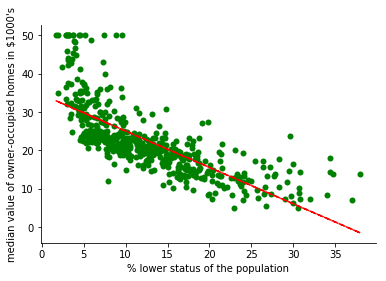

In [6]:
# enter your code here
fig, ax = plt.subplots()
ax.scatter(boston['LSTAT'], bdata.target,color = "green", lw=0)
plt.xlabel('% lower status of the population')
plt.ylabel('median value of owner-occupied homes in $1000\'s')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

z = np.polyfit(boston['LSTAT'], bdata.target, 1)
p = np.poly1d(z)
plt.plot(boston['LSTAT'],p(boston['LSTAT']),"r--")

plt.show()



---

##Part 2: Experimental Setup


###2.1 Begin by writing a function to compute the Root Mean Squared Error for a list of numbers


In [7]:
"""
Function
--------
compute_rmse

Given two arrays, one of actual values and one of predicted values,
compute the Roote Mean Squared Error

Parameters
----------
predictions : array
    Array of numerical values corresponding to predictions for each of the N observations

yvalues : array
    Array of numerical values corresponding to the actual values for each of the N observations

Returns
-------
rmse : float
    Root Mean Squared Error of the prediction

Example
-------
>>> print compute_rmse((2,2,3),(0,2,6)
2.16
"""
def compute_rmse(predictions, yvalues):
    rmse = 0
    for i in range(0,len(predictions)):
        rmse +=(predictions[i]-yvalues[i])**2
    return round((rmse/len(predictions))**0.5,2)
print (compute_rmse((2,2,3),(0,2,6)))

2.08


###2.2 Divide data into training and testing datasets


In [42]:
np.random.seed(seed=13579)

boston['rand'] = boston.apply(lambda row: np.random.rand(), axis=1)
boston['train'] = (boston['rand']>.34)
bdata_train = boston[boston['train']]
bdata_test = boston[(boston['rand']<=.34)]

###2.3 Use a very bad baseline for prediction, and compute RMSE


In [43]:
avg = statistics.mean(bdata_train['MEDV'])
predictions = [avg]*len(bdata_test)
print(compute_rmse(predictions, bdata_train['MEDV'].values))
print(compute_rmse(predictions, bdata_test['MEDV'].values))

10.08
7.8


The RMSE for the training set is not so different from that for the testing set. This is expected because the test and training sets are randomly selected, so that they are expected to have similar mean, variance and distribution. Therefore, they should have similar RMSE.

---

##Part 3: Nearest Neighbors


###3.1 Nearest Neighbors: Distance function


In [44]:
"""
Function
--------
distance

Given two instances and a value for L, return the L-Norm distance between them

Parameters
----------
x1, x2 : array
    Array of numerical values corresponding to predictions for each of the N observations

L: int
    Value of L to use in computing distances

Returns
-------
dist : float
    The L-norm distance between instances

Example
-------
>>> print distance((3,4),(6,8),2)
7

"""
def distance(x1, x2, L):
    dist = 0
    for i in range(0,len(x1)):
        dist += (x1[i]-x2[i])**L
    dist = dist**(1/L)
    return dist

print (distance((3,4),(6,8),2))

5.0


###3.2 Basic Nearest Neighbor algorithm


In [111]:
"""
Function
--------
nneighbor

Given the test data, training data and a value for L, find the MEDV calue of the closest training instance and return the MEDV value

Parameters
----------
test: dataFrame
    The test data

train: dataFrame
    The training data
    
features: array<string>
    The features that are considered

L: int
    Value of L to use in computing distances

Returns
-------
rmse: float
    Root Mean Squared Error of the prediction

time_taken: float
    Time taken to run the algorithm

"""
import time
def nneighbor(test, train, features, L):
    start_time = time.time()
    
    predictions = []
    for index_test,row_test in test.iterrows():
        test_point = []
        for f in features:
                test_point.append(row_test[f])
                
        minDist = -1
        for index_train, row_train in train.iterrows():
            train_point = []
            for f in features:
                train_point.append(row_train[f])
            currDist = distance(test_point,train_point,L)
            if minDist == -1 or currDist < minDist:
                minDist = currDist
                nn = row_train # nearest neighbour
        predictions.append(nn['MEDV'])
    
    rmse = compute_rmse(predictions, test['MEDV'].values)
    
    time_taken = round(time.time() - start_time,2)
    return rmse, time_taken

nn = nneighbor(bdata_test, bdata_train,['CRIM','RM'], 2)
print("RMSE: "+str(nn[0]))
print("Time taken: " + str(nn[1]) + " seconds")

RMSE: 7.32
Time taken: 6.24 seconds


###3.3 Results and Normalization


In [131]:
"""
Function
--------
normalize
    Given the array, return the normalized array


Parameters
----------
    raw_data: array


Returns
-------
    normalized_data: array

"""
def normalize(raw_data):
    #your code here
    mean = statistics.mean(raw_data)
    sd = statistics.stdev(raw_data)
    
    normalized_data=[]
    for i in raw_data:
        normalized_data.append((i-mean)/sd)
    return normalized_data

#your additional code here
def normalized(dataset, features):
    normalized = pd.DataFrame(data={'MEDV':dataset['MEDV'],
                                    'rand':dataset['rand']})
    
    for f in features:
        normalized[f]=normalize(dataset[f])
    return normalized

features = ['CRIM','RM']
nn_normalized = nneighbor(normalized(bdata_test,features), normalized(bdata_train,features),features, 2)
print("RMSE: "+str(nn_normalized[0]))
print("Time taken: " + str(nn_normalized[1]) + " seconds")

RMSE: 8.03
Time taken: 3.72 seconds


The RMSE doesn't change a lot when normalized, but slightly increases

###3.4 Optimization


In [119]:
featureses=[['LSTAT','DIS'],['INDUS','ZN'],['CRIM','RM','LSTAT','DIS'],['CRIM','RM','INDUS','ZN']]
Ls = [2,3,4,5]

for features in featureses:
    for L in Ls:
        nn = nneighbor(normalized(bdata_test,features), normalized(bdata_train,features), features, 2)
        print("Features: "+str(features)+"  L: "+str(L)+ "  RMSE: "+str(nn[0])
              +"  Time taken: " + str(nn[1]) + " seconds")

Features: ['LSTAT', 'DIS']  L: 2  RMSE: 7.09  Time taken: 3.71 seconds
Features: ['LSTAT', 'DIS']  L: 3  RMSE: 7.09  Time taken: 3.7 seconds
Features: ['LSTAT', 'DIS']  L: 4  RMSE: 7.09  Time taken: 3.71 seconds
Features: ['LSTAT', 'DIS']  L: 5  RMSE: 7.09  Time taken: 3.69 seconds
Features: ['INDUS', 'ZN']  L: 2  RMSE: 8.55  Time taken: 3.66 seconds
Features: ['INDUS', 'ZN']  L: 3  RMSE: 8.55  Time taken: 3.71 seconds
Features: ['INDUS', 'ZN']  L: 4  RMSE: 8.55  Time taken: 3.7 seconds
Features: ['INDUS', 'ZN']  L: 5  RMSE: 8.55  Time taken: 3.69 seconds
Features: ['CRIM', 'RM', 'LSTAT', 'DIS']  L: 2  RMSE: 5.17  Time taken: 4.62 seconds
Features: ['CRIM', 'RM', 'LSTAT', 'DIS']  L: 3  RMSE: 5.17  Time taken: 4.56 seconds
Features: ['CRIM', 'RM', 'LSTAT', 'DIS']  L: 4  RMSE: 5.17  Time taken: 4.59 seconds
Features: ['CRIM', 'RM', 'LSTAT', 'DIS']  L: 5  RMSE: 5.17  Time taken: 4.58 seconds
Features: ['CRIM', 'RM', 'INDUS', 'ZN']  L: 2  RMSE: 7.45  Time taken: 4.67 seconds
Features: ['CR

L in the distance function doesn't change the RMSE.
Combination of features ['CRIM', 'RM', 'LSTAT', 'DIS'] has the lowest RMS
My chioces of L and number of features do affect the running time. The more featurese I'm considering the more time the algorithm takes. For the L, I didn't see any consistent trend relating to the time taken.

### 3.5 Cross-Validation

The more you tinkered with your features and distance function, the higher the risk that you overfit your training data.  To prevent this sort of overfitting, you need to use cross-validation (see K-fold [cross-validation](http://en.wikipedia.org/wiki/Cross-validation_(statistics)).  Here you must implement a simple k-fold cross-validation algorithm yourself.  The function you write here will be used several more times in this problem set, so do your best to write efficient code! (Note that the sklearn package has a built-in [K-fold](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) iterator -- you should *not* be invoking that or any related algorithms in this section of the problem set.)

Use 10-fold cross-validation and report the average RMSE for Nearest Neighbors using Euclidean distance with CRIM and RM input features, as well as the total running time for the full run of 10 folds.  In other words, randomly divide your dataset into 10 equally-sized samples, and for each of 10 iterations (the "folds"), use 9 samples as "training data" (even though there is no training in k-NN!), and the remaining 1 sample for testing.  Compute the RMSE of that particular test set, then move on to the next iteration.  Report the average RMSE across the 10 iterations.

In [137]:
# enter your code here
def k_fold(k, features, L):
    i = 0
    rmse = 0
    time = 0
    while(i<1-1/k**2):
        test = boston.loc[(boston['rand']>=i) & (boston['rand']<i+1/k)]
        train = boston.loc[(boston['rand']<i) | (boston['rand']>=i+1/k)]
        nn = nneighbor(test, train, features, L)
        rmse += nn[0]
        time += nn[1]
        i += 1/k
    return round(rmse/k,2), round(time,2)

res = k_fold(10,['CRIM','RM'], 2)
print("RMSE: "+str(res[0]))
print("Time taken: " + str(res[1]) + " seconds")

RMSE: 7.02
Time taken: 23.06 seconds


###3.6 K-Nearest Neighbors Algorithm


In [128]:
"""
Function
--------
knn
    Given the data set, return the rmse and time taken for knn algorithmn

    Keep a priority queue, which stores K nearest nerighbours. Take the mean of the training data as the prediction.

Parameters
----------
test: DataFrame
    Test data set

train: DataFrame
    Training data set
    
features: array<string>
    The features that are considered

L: int
    Parameter for L-norm

K: int
    Parameter for K nearest neighbours


Returns
-------
rmse: float

time_taken: float
"""
def knn(test, train, features, L, K):
    start_time = time.time()
    
    predictions = []
    for index_test,row_test in test.iterrows():
        nn={} # nearest neighbours
        bar=0 # the MAX dist in nn; the threshold to join nn
        test_point = []
        for f in features:
            test_point.append(row_test[f])
        
        for index_train, row_train in train.iterrows():
            train_point = []
            for f in features:
                train_point.append(row_train[f])
            currDist = distance(test_point,train_point,L)
            if len(nn)<K:
                nn[currDist]=row_train['MEDV']
                bar = max(nn.keys())
            elif currDist < bar:
                del nn[bar]
                nn[currDist]=row_train['MEDV']
                bar = max(nn.keys())
        predictions.append(statistics.mean(nn.values()))
    
    rmse = compute_rmse(predictions, test['MEDV'].values)
    
    time_taken = round(time.time() - start_time,2)
    return rmse, time_taken

"""
Function
--------
k_fold_KNN
    Modified k fold function, where you can specify the K for nearest neighbour algorithm

Parameters
----------
dataset: DataFrame
    The dataset used
    
k: int
    Parameter for k fold

K: int
    Parameter for K nearest neighbours

features: array<string>
    The features that are considered

L: int
    Parameter for L-norm
    

Returns
-------
rmse: float
"""
def k_fold_KNN(dataset, k, K, features, L):
    i = 0
    rmse = 0
    time = 0
    while(i<1-1/k**2):
        test = dataset.loc[(dataset['rand']>=i) & (dataset['rand']<i+1/k)]
        train = dataset.loc[(dataset['rand']<i) | (dataset['rand']>=i+1/k)]
        nn = knn(test, train, features, L, K)
        rmse += nn[0]
        time += nn[1]
        i += 1/k
    return round(rmse/k,2), round(time,2)


res = k_fold_KNN(boston, 10, 3, ['CRIM','RM'], 2)
print("RMSE: "+str(res[0]))
print("Time taken: " + str(res[1]) + " seconds")

RMSE: 5.62
Time taken: 24.29 seconds


###3.7 Using cross validation to find K


In [132]:
features = ['CRIM', 'ZN', 'RM', 'AGE', 'DIS', 'TAX']
K=1
K_list = []
RMSE = []
normalized = normalized(boston,features)
while(K<26):
    K_list.append(K)
    RMSE.append(k_fold_KNN(normalized, 10, K, features, 2)[0])
    K += 1

Value of K: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
RMSE: [6.04, 5.29, 4.99, 4.91, 4.98, 4.98, 5.06, 5.1, 5.1, 5.13, 5.16, 5.19, 5.22, 5.24, 5.25, 5.31, 5.3, 5.3, 5.36, 5.37, 5.41, 5.42, 5.44, 5.44, 5.46]


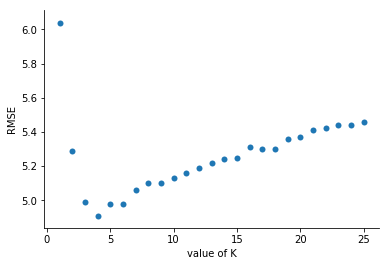

In [133]:
print("Value of K: "+str(K_list))
print("RMSE: "+str(RMSE))

fig, ax = plt.subplots()
ax.scatter(K_list, RMSE, lw=0)
plt.xlabel('value of K')
plt.ylabel('RMSE')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

The rmse goes down when the value of K increases until 4. After 4, it seems the rmse is positively related to the value of K.
Therefore, for this model, I think K = 4 is a reasonable choice.